In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from qiskit import *
from qiskit.extensions.standard import *

* Find the groud state of the Hamiltonian:$H=\begin{pmatrix}
0 & 0 &0  & 0 \\
0 & -1 & 1 & 0 \\
0 & 1 & -1 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}.$


## #VQE ON A **IDEAL** SIMULATOR
[See it also in the noisy case](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noisy.Simulator.Code2.ipynb).

* Let first have the eigenvalues of $H$ and find the lowest one which corresponds to the lowest energy. We will use for this some ``` Numpy ``` tools:

In [2]:
H = np.mat("0 0 0 0; 0 -1 1 0; 0 1 -1 0; 0 0 0 0") #The Hamiltonian matrix
print("The eigenvalues of H :", np.linalg.eigvals(H))
print('The exact ground state energy is: ', np.linalg.eigvals(H)[1])


The eigenvalues of H : [ 0. -2.  0.  0.]
The exact ground state energy is:  -2.0


* As we can see the lowest eigenvalue is $-2$.

## Variational Quantum Eingensolver (VQE):

### - Now let us find this value using VQE and see the accuracy of its result

* We need to be able to express the Hamiltonian matrix in a quantum circuit, so that expectations values can be measured using the quantum computer.

* To do that we need to decompose $H$ into the sum of tensor products of Pauli operators, multiplied by some constant coefficients: $H = a \cdot II + b \cdot XX + c \cdot ZZ + d \cdot YY.$

This equation leads to $4$ equations with $4$ variables, which can be written as $Ax=C$ :
$$
\begin{pmatrix}
1 & 0 & 1  & 0 \\
0 & 1 & 0 & -1 \\
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 1
\end{pmatrix}.
\begin{pmatrix}
a \\
b \\
c \\
d
\end{pmatrix} = 
\begin{pmatrix}
0 \\
0 \\
-1 \\
1
\end{pmatrix}
$$
We can solve this manually, or use again ```Numpy``` for this task to compute the coefficients $a$, $b$, $c$, and $d$ :

In [6]:
A = np.array([[1,0,1,0],[0,1,0,-1],[1,0,-1,0],[0,1,0,1]])
C = np.array([0,0,-1,1])
S = np.linalg.solve(A,C) # x = A^-1 * C
a, b, c, d = S[0], S[1], S[2], S[3]
print("a:", a,"\nb:", b, "\nc:", c, "\nd:", d)

a: -0.5 
b: 0.5 
c: 0.5 
d: 0.5


#### And voila!  $H = -0.5 \cdot II + 0.5 \cdot XX + 0.5 \cdot ZZ + 0.5 \cdot YY.$

* I'm going to convert $H$ to a dictionary for a purposeful reason:

In [7]:
H ={'II':a, 'XX':b, 'ZZ':c,'YY':d}
print(H)

{'II': -0.5, 'XX': 0.5, 'ZZ': 0.5, 'YY': 0.5}


### - The Ansatz:

* The variational method consiste of calculating the expectation value of $H$, over a multiple trial wavefunctions to get the minimum one $min_\theta\left\langle \psi \right| H \left| \psi \right\rangle = lowest\; energy$.

* So we initialize our circuit with a best guess, or ansatz: $$(I \otimes X).(C-Not).(R_z(\theta) \otimes I).(H \otimes I) \left| 0 \right\rangle \otimes \left| 0 \right\rangle$$

In [15]:
# The ansatz initialization
def ansatz_init(circuit, parameter):
    q = circuit.qregs[0]
    circuit.h(q[0])
    circuit.rz(parameter, q[0])
    circuit.cx(q[0], q[1])
    circuit.x(q[1])
    return circuit

### - Transfer to the $Z\; basis$:
* Now to calculate the expectation value, we need to be very careful about the basis.
* The only physical measurement that a quantum computer can do, is in the Z basis {${\left| 0 \right\rangle; \left| 1 \right\rangle}$}. And as we can see, the Hamiltonian is decomposed into a linear combination of Pauli's matrices, as these form a basis for hermitian matrices. Hence, we have three kinds of measurement basis:
$$Z basis: {\left| 0 \right\rangle; \left| 1 \right\rangle},\qquad X basis: {\left| + \right\rangle; \left| - \right\rangle},\qquad Y basis: {\left| +i \right\rangle; \left| -i \right\rangle}.$$
Thus, we need to express the last two basis in the $Z\;basis$ :

 * $X\;basis$ in term of $Z\;basis$; we get the matrix: $H^{'} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}$.

 * $Y\;basis$ in term of $Z\;basis$; we get the matrix: $Y^{'} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
i & -i
\end{pmatrix}$.

<b> Those two matrices transfer from {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} to {${\left| + \right\rangle; \left| - \right\rangle}$} and {${\left| +i \right\rangle; \left| -i \right\rangle}$} respectevly.
    
* Every quantum state $\left| \psi \right\rangle$ can be expressed in different sets of basis, so if we want it to be written in the {$\left| 0 \right\rangle; \left| 1 \right\rangle$} basis, to get the count of the measurement and calculate the expectations values, we process as follow:

 * We apply the inverse of $H^{'}$ to go from the {${\left| + \right\rangle; \left| - \right\rangle}$} basis to the {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} basis; consequently, we get the matrix: $H_{gate} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}$. (It is the Hadamard gate)
 * We apply the inverse of $Y^{'}$ to go from the {${\left| +i \right\rangle; \left| -i \right\rangle}$} basis to the {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} basis; then, we get the matrix: $Y_{gate} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & -i\\
1 & i
\end{pmatrix}$.

In [16]:
H_gate = U2Gate(0, np.pi).to_matrix()
print("H_gate:")
print((H_gate * np.sqrt(2)).round(5))

Y_gate = U2Gate(0, np.pi/2).to_matrix()
print("Y_gate:")
print((Y_gate * np.sqrt(2)).round(5))

H_gate:
[[ 1.+0.j  1.-0.j]
 [ 1.+0.j -1.+0.j]]
Y_gate:
[[ 1.+0.j -0.-1.j]
 [ 1.+0.j  0.+1.j]]


In [17]:
# transfer to the Z basis measurement circuit
def z_measure_circ(parameter, measure):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansate in the circuit
    circuit = ansatz_init(circuit, parameter)

    # measurement
    if measure == 'XX':
        circuit.barrier(q[0],q[1])
        circuit.u2(0, np.pi, q[0])
        circuit.u2(0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'ZZ':
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'YY':
        circuit.barrier(q[0],q[1])
        circuit.u2(0, np.pi/2, q[0])
        circuit.u2(0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    else:
         raise ValueError('Input should be "XX" or "YY" or "ZZ"')

    return circuit

* The counts result is returned in qiskit, in a form of a dictionary, so I will define a function ```get_from``` that returns the values in the dictionary. Also, it will be useful for the Hamiltonian dictionary created above.

In [18]:
# If key is missing than return 0 otherwise the corresponding value.
def get_from(d: dict, key: str):

    value = 0
    if key in d:
        value = d[key]
    return value

### - The expectation value:

* The expectation value in the case of two qubits, is calculated considering the computational basis (Z-Axis) as follow: 
$$\frac{1}{N}.(N_{00}\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle + N_{11}\left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle + N_{10}\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle + N_{01}\left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle)$$
In which: 
$$\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle = \left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle = 1$$
and 
$$\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle = \left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle = -1$$
therefore the expectation value become:
$$\frac{1}{N}.((N_{00} + N_{11}) - (N_{10} + N_{01}))$$
where $N$ is the number of shots, and $N_{00}$, $N_{11}$, $N_{10}$, $N_{01}$ are the number of time the state $\left| 00 \right\rangle$, $\left| 11 \right\rangle$, $\left| 10 \right\rangle$, $\left| 01 \right\rangle$ are measured respectively.

In [19]:
#calculate the expectation value for each Pauli's gate
def expec_value(parameter, measure):
    # measure in the right basis, then use the counts to compute the expectation value.
    if measure == 'II':
        return 1
    if measure == 'XX':
        circuit = z_measure_circ(parameter, 'XX')
    elif measure == 'ZZ':
        circuit = z_measure_circ(parameter, 'ZZ')
    elif measure == 'YY':
        circuit = z_measure_circ(parameter, 'YY')
    else:
        raise ValueError('Input should be "II" or "XX" or "ZZ" or "YY"')
    
    shots = 1000
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expectation_value = ((get_from(counts, '00')+get_from(counts, '11')) - 
                         (get_from(counts,'10')+get_from(counts, '01'))) / shots

    return expectation_value

* create a function ```sum_expec``` that sums up all the expectation value inside the one of the Hamiltonian, multiply them by their coefficients, and returns the final result.
$$\left\langle H \right\rangle = a \cdot \left\langle \psi \right| II \left| \psi \right\rangle + b \cdot \left\langle \psi \right| XX \left| \psi \right\rangle + c \cdot \left\langle \psi \right| ZZ \left| \psi \right\rangle + d \cdot \left\langle \psi \right| YY \left| \psi \right\rangle.$$

In [20]:
def sum_expec(parameter):
    
    expec_value_II = get_from(H, 'II') * expec_value(parameter, 'II') #a*<II>
    expec_value_XX = get_from(H, 'XX') * expec_value(parameter, 'XX') #b*<XX>
    expec_value_ZZ = get_from(H, 'ZZ') * expec_value(parameter, 'ZZ') #c*<ZZ>
    expec_value_YY = get_from(H, 'YY') * expec_value(parameter, 'YY') #d*<YY>
    # summing the expectations results
    sum_result = expec_value_II + expec_value_XX + expec_value_ZZ + expec_value_YY
    
    return sum_result

### Using the optimizer:
* the ansatz we had initialize have one degree of freedom i.e. it depends in one parameter $\theta$ (rotation) on which she can vary, so the trials wavefunctions depend on $\theta$; $\left| \psi(\theta) \right\rangle$.

<b> So at the first time, we are going to count on an optimizer called ```minimize``` from ```scipy.optimize```, to search the best angle $\theta$, therefore the best wavefunction $\left| \psi(\theta) \right\rangle$, which minimize the expectation value: $min_\theta\left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle = lowest\; energy\;$.

In [21]:
parameter = 1 #initialize an arbitrary angle

tol = 1e-3 #tolerance for optimization precision.
#Inject the sum_expec result inside the minimizer function
sum_expec_result = minimize(sum_expec, parameter, method="Powell", tol=tol)

print('The exact ground state energy is: {}'.format(eigenvalue[1]))
print('The estimated ground state energy from VQE algorithm is: {}'.format(sum_expec_result.fun))
print("\nThe optimal parameter is : {} ".format(sum_expec_result.x))

The exact ground state energy is: -2.0
The estimated ground state energy from VQE algorithm is: -2.0

The optimal parameter is : 3.1042756418412325 


* As can be seen, the optimizer can ﬁnd the best angle $\theta = 3.1042756418412325\;$ for the global minimum energy $ E = \left\langle \psi \right| H \left| \psi \right\rangle = -2.0$ (in arbitrary units) as expected.

### Using **```for```**  loop:
<b> Here, classical optimization is not necessary, since we have only one parameter to sweep over. Therefore it is obvious that we are going to loop over a set of values in the range $[0, 2\pi)$ :

In [22]:
angles = np.linspace(0.0, 2.0 * np.pi, 25) # an array of angles in [0,2pi)

lowest_array=[] #  empty regular list
for parameter in angles:
    lowest = sum_expec(parameter)
    lowest_array.append(lowest)
    low = np.array(lowest_array) # transformed to a numpy array

Some ```matplotlib``` functions to plot a nice graph :)

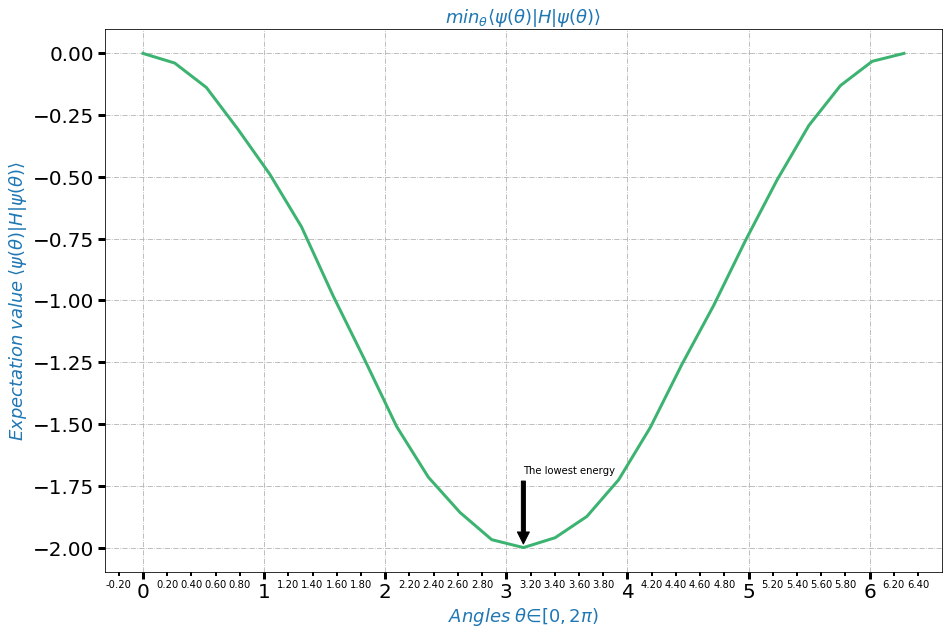

The intersection between the value of the optimizer angle and the constructed graph is the lowest energy:  -1.995438704475237


In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.plot(angles, low, linewidth=3, color='mediumseagreen')


##The 3.141 position of the arrow is chosen, because It was the best angle I got after differnt execution
ax.annotate('The lowest energy', xy=(3.141, -2), xytext=(3.141, -1.7),
             arrowprops=dict(facecolor='black', shrink=0.05),)
#make the minor graduation
def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x
ax.xaxis.set_minor_locator(AutoMinorLocator()) #plot the minor graduation
ax.xaxis.set_minor_formatter(FuncFormatter(minor_tick)) #plot the minor graduation numbers

ax.tick_params(which='both', width=2) #controle both graduation for x and y axis
ax.tick_params(which='major', length=7) #controle the major graduation the n° of grad
ax.tick_params(which='minor', length=4, color='black') #control the minor graduation le n° de grad
ax.tick_params(labelcolor='black', labelsize=20, width=3) #controle the major graduation

plt.xlabel(r'$Angles \; \theta ∈ [0,2\pi)$', {'color': 'C0', 'fontsize': 18})
plt.ylabel(r'$Expectation \; value \; \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.title(r'$min_\theta \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.grid(linestyle='-.')
plt.show()
# Use the interpolation numpy function, where its utilise the best angle given by the optimizer, to see if
# its give us the right ground state in Y-axis in the graph below: (f(angle) = ?)
inter = np.interp( sum_expec_result.x ,angles,low)
print('The intersection between the value of the optimizer angle and the constructed graph is the lowest energy: ',inter)

<b>Enumerating the expectation values for all angles, lead to a lowest state energy equal to the one obtained with the optimizer!

N.B: The best angle I got after differnt execution of the optimizer was, $\theta = 3.141... \approx \pi$ .
    
&#10173; Final results: $$\left\langle H \right\rangle_{optimizer} = -2.0,\qquad \theta_{optimizer} = 3.1042756418412325$$
    
$$\left\langle H \right\rangle_{for\;loop} = -2.0,\qquad \theta_{for\;loop} \approx 3.15$$

&#10170; **I searched the lowest energy for the same Hamiltonian, using the VQE in a noisy environment. Moreover, I used another code implementation  and take the same step (use optimizer and for loop) I toke here to get the values.** [See it in my github](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noisy.Simulator.Code2.ipynb)

https://arxiv.org/abs/1304.3061

https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb